In [154]:
import pandas as pd
import numpy as np
import scipy
import os
from Bio import SeqIO, SearchIO
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from typing import List, Optional, Callable


# coding vs noncoding prok

In [155]:
activations_path = "/large_storage/hielab/changdan/evo2_gtdb_complete_activations_sae-a6u40nnl-layer26-batch-topk-tied-expansion_8-k_64/"
fastas_path = "/large_storage/hielab/changdan/evo_sae_1_20_25_prokaryotic_dataset_final_permission_fixed/gtdb_rep_genomes_complete/"

contig_dict = {}

chunk_size = 50_000

# for f in tqdm(os.listdir(fastas_path)[:20]):
for f in tqdm(os.listdir(fastas_path)[:1]):
    fasta_name = f[:-4]
    contig_list = list(SeqIO.parse(fastas_path + f, 'fasta'))

    for contig_record in contig_list:
        # sparse = scipy.sparse.load_npz(f"{activations_path}{fasta_name}/{contig_record.id}.npz")
        sparse_chunks = []
        for start in range(0, len(contig_record), chunk_size):
            end = min(start + chunk_size, len(contig_record))
            sparse_chunks.append(scipy.sparse.load_npz(f"{activations_path}{fasta_name}/{contig_record.id}_{start}_{end}.npz"))
        sparse = scipy.sparse.vstack(sparse_chunks)
            
        contig_dict[(fasta_name, contig_record.id)] = sparse

  0%|          | 0/1 [00:00<?, ?it/s]

In [156]:
# contig_dict

In [157]:
contigs = set([c[0] for c in contig_dict])
contigs

{'GCF_009646115.1'}

In [158]:
gb_path = "/home/changdan/projects/evo_sae_concepts_GTDB/output/gtdb_rep_genomes_complete_bakta_annotations_gbff/" # GCF_009646115.1_bakta.gbff

gb_dict = {}

# for f in tqdm(os.listdir(gb_path)[:]):
for c in tqdm(contigs):
    name = c
    f = name + "_bakta.gbff"
    # name = f.split("_bakta.gbff")[0]
    gb = list(SeqIO.parse(f"{gb_path}{f}", 'genbank'))
    for record in gb:
        gb_dict[(name, record.id)] = record

  0%|          | 0/1 [00:00<?, ?it/s]

In [161]:
# gb_dict

In [182]:
coding_means = []
noncoding_means = []

for f, c in tqdm(contig_dict):
    features = contig_dict[(f, c)]
    mask = np.zeros(features.shape[0])
    gb = gb_dict[(f, c)]
    for g in gb.features:
        if g.type == 'CDS':
            s, e = g.location.start, g.location.end
            mask[s:e] = 1
    if mask.sum() == 0 or mask.sum() == mask.shape[0]: continue
        
    coding_mean = features[mask == 1].mean(axis=0)
    noncoding_mean = features[mask != 1].mean(axis=0)
    
    # coding_mean = (features[mask == 1] > 0).mean(axis=0)
    # noncoding_mean = (features[mask != 1] > 0).mean(axis=0)
    
    coding_means.append(coding_mean)
    noncoding_means.append(noncoding_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

In [183]:
diff = (np.vstack(coding_means) - np.vstack(noncoding_means)).mean(axis=0)
diff.shape

(1, 32768)

In [184]:
diff_flat = np.array(diff).flatten()

In [185]:
np.save("../output/coding_noncoding_diff_prok.npy", diff_flat)
# np.save("../output/coding_noncoding_diff_prok2.npy", diff_flat)

# euk vs prok

In [59]:
genome_path_t2t = "/large_storage/hielab/changdan/euk_genomes/GCF_009914755.1_T2T-CHM13v2.0_genomic.gbff"
activations_path_t2t = "/large_storage/hielab/changdan/evo2_T2T_activations_sae-a6u40nnl-layer26-batch-topk-tied-expansion_8-k_64/"

In [60]:
fa = SeqIO.parse(genome_path_t2t, "genbank")

In [61]:
chroms = [g for g in fa]
len(chroms)

24

In [63]:
for c in chroms:
    print(c.id)
    print(c.description)
    print(len(c))
    print()

NC_060925.1
Homo sapiens isolate CHM13 chromosome 1, alternate assembly T2T-CHM13v2.0
248387328

NC_060926.1
Homo sapiens isolate CHM13 chromosome 2, alternate assembly T2T-CHM13v2.0
242696752

NC_060927.1
Homo sapiens isolate CHM13 chromosome 3, alternate assembly T2T-CHM13v2.0
201105948

NC_060928.1
Homo sapiens isolate CHM13 chromosome 4, alternate assembly T2T-CHM13v2.0
193574945

NC_060929.1
Homo sapiens isolate CHM13 chromosome 5, alternate assembly T2T-CHM13v2.0
182045439

NC_060930.1
Homo sapiens isolate CHM13 chromosome 6, alternate assembly T2T-CHM13v2.0
172126628

NC_060931.1
Homo sapiens isolate CHM13 chromosome 7, alternate assembly T2T-CHM13v2.0
160567428

NC_060932.1
Homo sapiens isolate CHM13 chromosome 8, alternate assembly T2T-CHM13v2.0
146259331

NC_060933.1
Homo sapiens isolate CHM13 chromosome 9, alternate assembly T2T-CHM13v2.0
150617247

NC_060934.1
Homo sapiens isolate CHM13 chromosome 10, alternate assembly T2T-CHM13v2.0
134758134

NC_060935.1
Homo sapiens isol

In [94]:
chunk_size = 50000

def load_contig(contig, num_chunks=None):
    chunks = []

    i = 0
    for start in tqdm(range(0, len(contig), chunk_size)):
        i += 1
        if num_chunks is not None and i > num_chunks: break
        stop = min(start + chunk_size, len(contig))
        sparse = scipy.sparse.load_npz(f"{activations_path_t2t}{contig.id}/{contig.id}_{start}_{stop}.npz")
        chunks.append(sparse)

    chunks_cat = scipy.sparse.vstack(chunks)

    return chunks_cat

In [95]:
chroms[19]

SeqRecord(seq=Seq('AACCCTAACCCTAACCCTAACCCTACCCTAACCCTAACCCTAACCCTAACCCTT...TTA'), id='NC_060944.1', name='NC_060944', description='Homo sapiens isolate CHM13 chromosome 20, alternate assembly T2T-CHM13v2.0', dbxrefs=['BioProject:PRJNA807723', 'BioSample:SAMN03255769', 'Assembly:GCF_009914755.1'])

In [113]:
activations_human = load_contig(chroms[19], 600)

  0%|          | 0/1325 [00:00<?, ?it/s]

In [114]:
mean_proks = []

for f, c in tqdm(contig_dict):
    features = contig_dict[(f, c)]
    mean_proks.append(features.mean(axis=0))

  0%|          | 0/30 [00:00<?, ?it/s]

In [115]:
diff = activations_human.mean(axis=0) - np.vstack(mean_proks).mean(axis=0)
diff.shape

(1, 32768)

In [116]:
diff_flat = np.array(diff).flatten()

In [117]:
np.save("../output/euk_vs_prok.npy", diff_flat)

# coding vs noncoding euks

In [140]:
mask = np.zeros(activations_human.shape[0])
for f in chroms[19].features:
     if f.type == 'CDS':
        for part in f.location.parts:
            s, e = part.start, part.end
            if e > mask.shape[0]: continue
            mask[s:e] = 1

In [143]:
diff = activations_human[mask == 1].mean(axis=0) - activations_human[mask != 1].mean(axis=0)
diff.shape

(1, 32768)

In [145]:
diff_flat = np.array(diff).flatten()

In [147]:
np.save("../output/coding_noncoding_diff_euk.npy", diff_flat)

# DFT

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import dft

def analyze_dft(arr, sampling_rate=1.0, plot=True, title='DFT Analysis'):
    # Flatten the input array if it's 2D
    if arr.ndim == 2:
        arr_1d = arr.flatten()
    else:
        arr_1d = arr.copy()
    
    n = len(arr_1d)
    
    # Compute DFT
    dft = np.fft.fft(arr_1d)
    
    # Compute frequency bins
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    
    magnitude = np.abs(dft)
    
    # Create visualization if requested
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(12, 8), dpi=200)
        
        # Original signal
        time = np.arange(n) / sampling_rate
        axes[0].plot(time, arr_1d, 'b-', linewidth=1.5)
        axes[0].set_title('Original Signal')
        axes[0].set_xlabel('Position (bp)')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)
        
        # Magnitude spectrum (positive frequencies only)
        positive_freqs = freqs[:n//2]
        positive_magnitude = magnitude[:n//2]
        # positive_freqs = freqs[:]
        # positive_periods = 1 / freqs[:]
        # positive_magnitude = magnitude[:]
        axes[1].plot(positive_freqs, positive_magnitude, 'r-', linewidth=1.5)
        axes[1].set_title('Magnitude Spectrum')
        axes[1].set_xlabel(r'Frequency (bp$^{-1}$)')
        # axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Magnitude')
        axes[1].grid(True, alpha=0.3)


        # positive_freqs = freqs[:n//2]
        # positive_magnitude = magnitude[:n//2]
        
        # # Calculate periods, excluding zero frequency (DC component)
        # # to avoid division by zero
        # valid_indices = positive_freqs > 0
        # valid_freqs = positive_freqs[valid_indices]
        # valid_magnitude = positive_magnitude[valid_indices]
        # periods = 1 / valid_freqs
        
        # axes[1].plot(periods, valid_magnitude, 'r-', linewidth=1.5)
        # axes[1].set_title('Magnitude Spectrum')
        # axes[1].set_xlabel('Period (s)')
        # axes[1].set_ylabel('Magnitude')
        # axes[1].grid(True, alpha=0.3)

        mask = positive_freqs > 0.1
        # mask = positive_freqs >= 0
        axes[2].plot(1 / positive_freqs[mask], positive_magnitude[mask])
        axes[2].set_title('Magnitude Spectrum')
        # axes[1].set_xlabel('Frequency (Hz)')
        axes[2].set_xlabel('Period (bp)')
        axes[2].set_ylabel('Magnitude')
        axes[2].grid(True, alpha=0.3)
        
        
        plt.tight_layout()
        plt.show()
    
    # Return results as a dictionary
    return {
        'dft': dft,
        'magnitude': magnitude,
        'freqs' : freqs,
        'signal': arr_1d
    }



In [179]:
arr = np.array(contig_dict[('GCF_009646115.1',
  'NZ_CP045720.1')][:, 19746].todense())

In [180]:
# arr_slice = arr[624000:624100]
# plt.plot(arr_slice)
# plt.show()

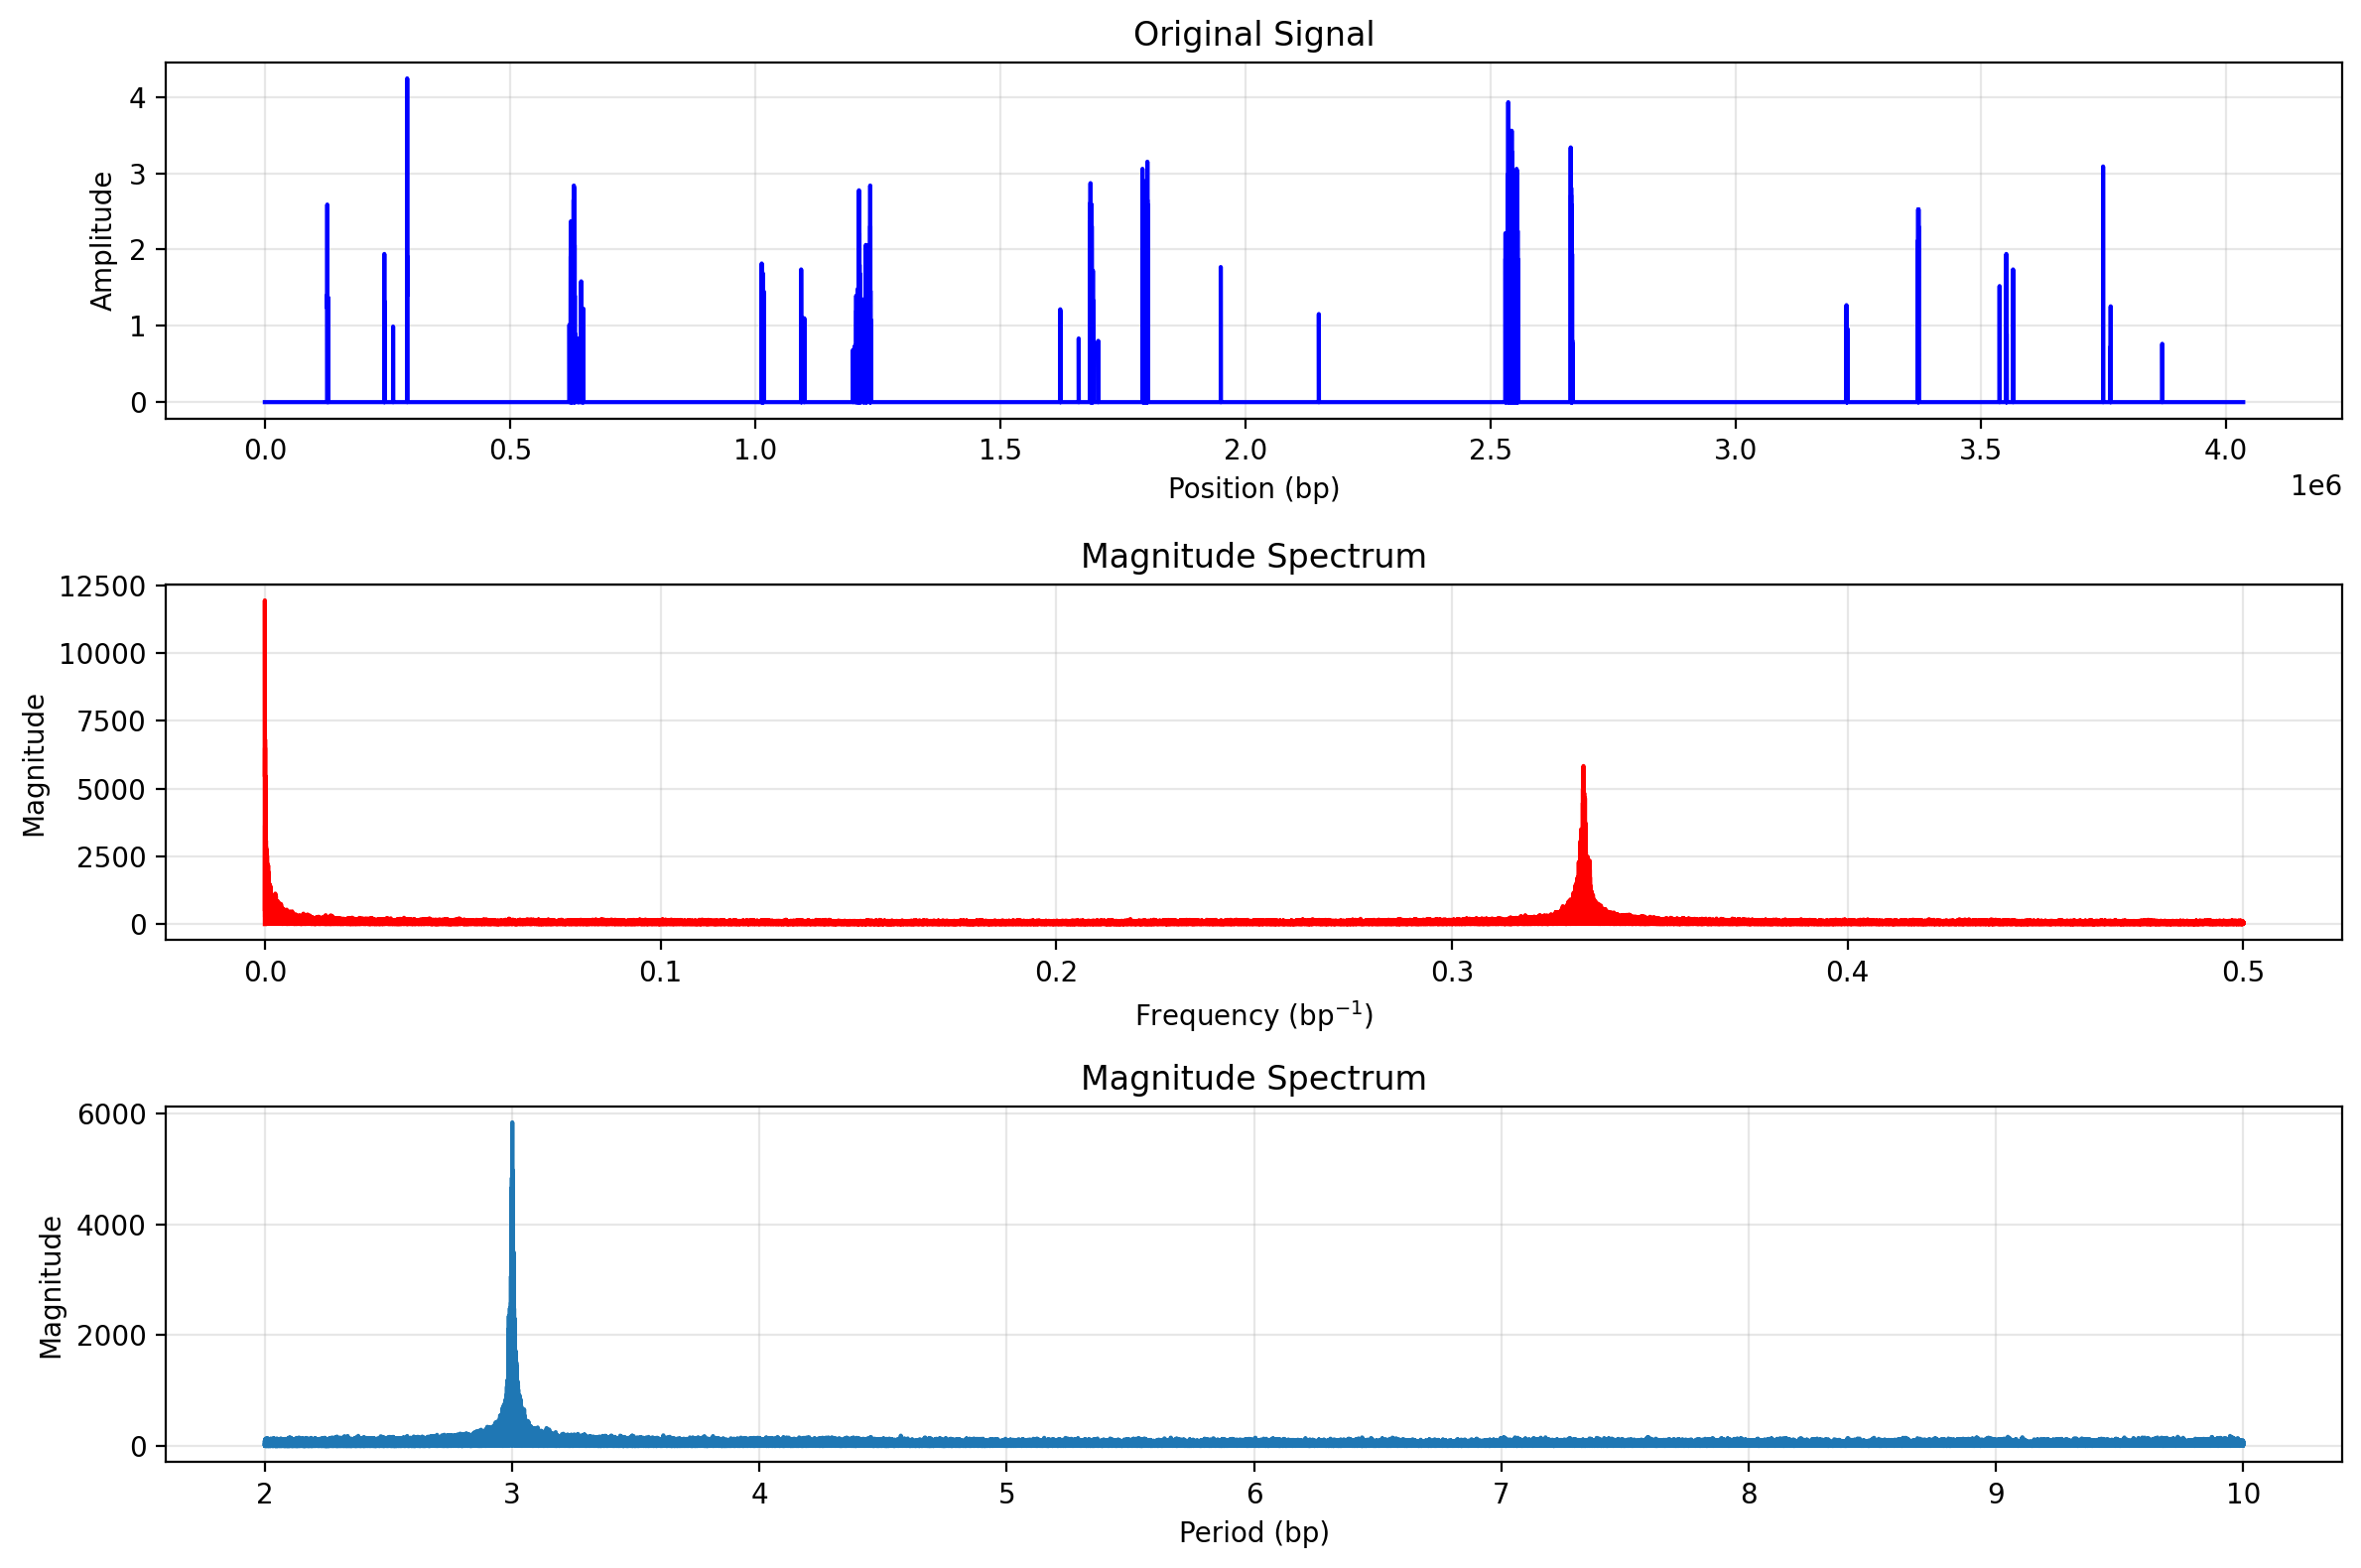

In [181]:
# results = analyze_dft(arr)
results = analyze_dft(arr - np.mean(arr))

In [72]:
n = arr.shape[0]
positive_freqs = results['freqs'][:n//2]
positive_periods = 1 / results['freqs'][:n//2]
positive_magnitude = results['magnitude'][:n//2]

/tmp/ipykernel_4141987/3823460785.py:3: RuntimeWarning: divide by zero encountered in divide
  positive_periods = 1 / results['freqs'][:n//2]


(0.1, 2118895.8)

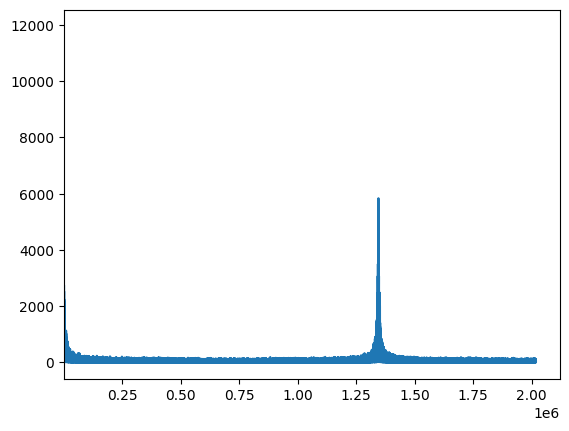

In [144]:
plt.plot(positive_magnitude)
plt.xlim(0.1, plt.xlim()[1])

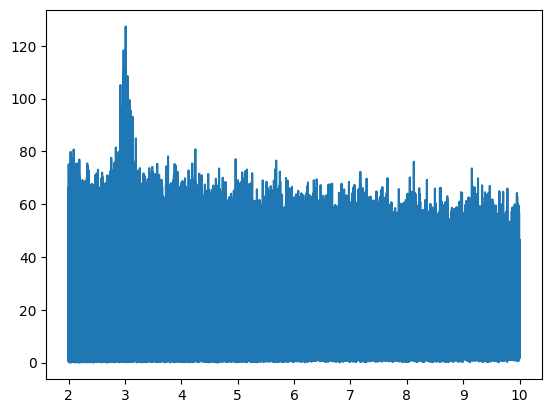

In [55]:
mask = positive_freqs > 0.1
plt.plot(1 / positive_freqs[mask], positive_magnitude[mask])

In [56]:
1 / positive_freqs[mask][positive_magnitude[mask].argmax()]

3.0118399185697773

In [57]:
positive_magnitude[mask].max()

127.30665082347345

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import dft

def analyze_dft(arr, sampling_rate=1.0, plot=True, title='DFT Analysis'):
    # Flatten the input array if it's 2D
    if arr.ndim == 2:
        arr_1d = arr.flatten()
    else:
        arr_1d = arr.copy()
    
    n = len(arr_1d)
    
    # Compute DFT
    dft = np.fft.fft(arr_1d)
    
    # Compute frequency bins
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    
    magnitude = np.abs(dft)
    
    positive_freqs = freqs[:n//2]
    positive_magnitude = magnitude[:n//2]
    
    mask = positive_freqs > 0.1
    
    peak_period = (1 / positive_freqs[mask])[positive_magnitude[mask].argmax()]
    peak_magnitude = positive_magnitude[mask].max()

    return peak_period, peak_magnitude

    


In [168]:
peak_periods = np.load("../output/NZ_CP045720.1_peak_periods.npy")
peak_magnitudes = np.load("../output/NZ_CP045720.1_peak_magnitudes.npy")

# peak_periods = np.load("../output/NC_060944.1_peak_periods.npy")
# peak_magnitudes = np.load("../output/NC_060944.1_peak_magnitudes.npy")

In [170]:
np.where((peak_periods > 5) & (peak_magnitudes > 10000))

(array([ 9573, 18591]),)

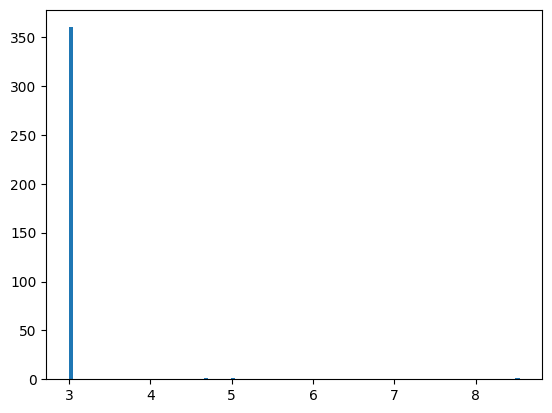

In [167]:
# plt.hist(peak_magnitudes, bins=100)
plt.hist(peak_periods[peak_magnitudes > 10000], bins=100)
plt.show()

In [60]:
np.where((peak_periods > 4) & (peak_magnitudes > 1000))

(array([  284,   826,  1452,  1518,  1743,  2941,  3000,  4112,  4603,
         4982,  5158,  5541,  5867,  5879,  5937,  6811,  7491,  7552,
         7668,  8126,  8177,  9222,  9573, 10653, 11384, 11670, 11812,
        11958, 12296, 12417, 12638, 12646, 12987, 13854, 14878, 15410,
        15491, 15716, 16115, 16126, 16610, 16733, 17150, 17337, 18252,
        18382, 18581, 18591, 18603, 19030, 19313, 19451, 19607, 19630,
        20395, 20707, 20777, 20915, 21445, 21671, 22126, 22569, 22619,
        22697, 22834, 23089, 23362, 23517, 23692, 23817, 23942, 24572,
        25144, 25327, 25590, 25615, 25871, 25962, 26653, 27144, 27814,
        27855, 27964, 28245, 28320, 28580, 28653, 29759, 29862, 30126,
        31136, 31580, 31934, 32472]),)

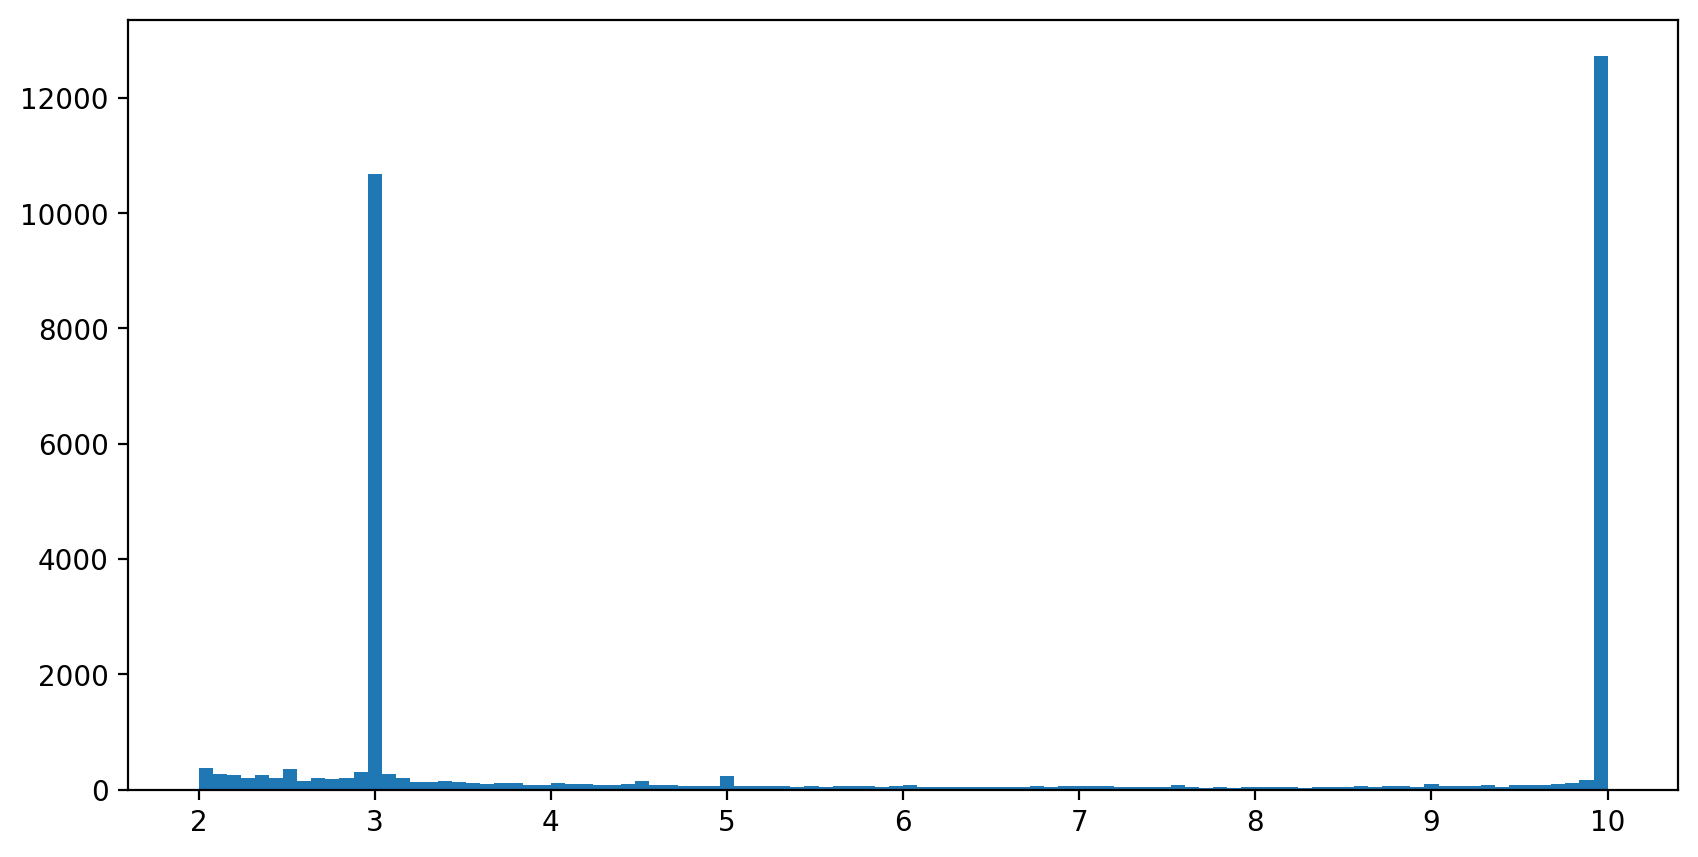

In [122]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.hist(peak_periods[peak_magnitudes > 100], bins=100)
plt.hist(peak_periods[:], bins=100)
plt.show()

In [23]:
# np.where(peak_periods == peak_periods[peak_magnitudes > 100].max())

(array([21671]),)

In [27]:
peak_periods[peak_magnitudes > 100]

array([3.01183992, 2.99928808, 2.99930814, ..., 3.00214599, 3.0000171 ,
       2.99979412])